## Intro to Web Scraping

In this post, we will find out What movies or TV shows share actors with our favorite movie or show by using Scrapy. The website I will scrape in this post is IMBD,  and explain the steps on how to scrape data from the web.

**steps:**
1) Locate the Starting IMDB Page
    -  Pick a favorite movie or TV show, and locate its IMDB page. For example, my favorite film is 'Spider-Man: No Way Home'. Its IMDB page is at: https://www.imdb.com/title/tt10872600/
2) Dry-Run Navigation:
    - First, click on the All Cast & Crew link. This will take us to a page with URL of the form '<original_url>fullcredits/'
    - Next, scroll until you see the Series Cast section. Click on the portrait of one of the actors. This will take us to a page with a different-looking URL. For example, the URL for Tom Holland is: https://www.imdb.com/name/nm4043618/?ref_=ttfc_fc_cl_t1
    - Finally, scroll down until we see the actor’s Filmography section. Note the titles of a few movies and TV shows in this section.
3) Initialize The Project
    - Our scraper is going to replicate step 2). Starting with the 'Spider-Man: No Way Home', it’s going to look at all the actors in that movie, and then log all the other movies or TV shows that they worked on.
4) Tweak Settings
    - add *CLOSESPIDER_PAGECOUNT = 20* in the settings.py file to prevents our scraper from downloading too much data while we’re still testing things out. We’ll remove this line later.

## Start with Scrapy

Before we starting the project, you may ask what is Scrapy. Briefy talk, Scrapy is a web-crawling framework written in Python. In order to use it, we need install it into our python environment (link for installation guide: https://docs.scrapy.org/en/latest/intro/install.html#intro-install). Once installed, we can start our first Scrapy project. <br>
- Open the terminal, and enter a directory where we’d like to store your code and run: <br> 
  *scrapy startproject IMBD_scraper* <br>
  This will create a IMBD_scraper folder with a lot of files inside, we dont need modfile most of them.
- Spiders are classes that you define and that Scrapy uses to scrape information from a website (or a group of websites). <br>
  They must subclass Spider and define the initial requests to make, optionally how to follow links in the pages, and how to parse the downloaded page content to extract data.
- I will name the code file as **imbd_spider.py** and save it under the **IMBD_scraper/spiders** directory in the project:<br>
  This is the code for **imbd_spider.py**
<br>
<br>

### overall of the imbd_spider.py
The details of the member functions explanation are followed by this code.

In [1]:
import scrapy

class ImdbSpider(scrapy.Spider):
    name = 'imdb_spider'
    
    start_urls = ['https://www.imdb.com/title/tt10872600/'] # start url

    def parse(self, response):
        next_page = response.css("a[href*='fullcredits']").attrib['href']  # get element that contain url

        if next_page: # identical to if next_page is not None
            next_page = response.urljoin(next_page) # extract the url
            yield scrapy.Request(next_page, callback = self.parse_full_credits) # call parse_full_credits


    def parse_full_credits(self, response):
        cast_link = [a.attrib["href"] for a in response.css("td.primary_photo a")]

        if cast_link:
            for c in cast_link:
                next_page = response.urljoin(c)
                yield scrapy.Request(next_page, callback = self.parse_actor_page) # call parse_actor_page


    def parse_actor_page(self, response):
        actor_name = response.css(".header").css("span.itemprop::text").get()

        for moive in response.css("div.filmo-category-section:not([style*='display:none;']) b"):
            yield {
                "actor" : actor_name, 
                "movie_or_TV_name" : moive.css("a::text").get()
            }

As we can see, there is Spider subclasses <u>scrapy.Spider</u> and defines some attributes and methods:
- **name**: identifies the Spider. It must be unique within a project, that is, you can’t set the same name for different Spiders.
- **start_urls**: must return an iterable of Requests (you can return a list of requests or write a generator function) which the Spider will begin to crawl from. Here I used https://www.imdb.com/title/tt10872600/ (Spider-Man: No Way Home).
- **parse()**, **parse_full_credits()**, and **parse_actor_page()**: methods that will be called to handle the response downloaded for each of the requests made. Here I have 3 prase() methods, I will explain those methods in details later.<br>
  The parse() method usually parses the response, extracting the scraped data as dicts and also finding new URLs to follow and creating new requests (Request) from them.
- **yield**: inbuilt way of saving and storing data

### parse(self, response)

In [2]:
def parse(self, response):
    next_page = response.css("a[href*='fullcredits']").attrib['href']  # get element that contain url

    if next_page: # identical to if next_page is not None
        next_page = response.urljoin(next_page) # extract the url
        yield scrapy.Request(next_page, callback = self.parse_full_credits) # call parse_full_credits

the start_url is link to this page, and we want jump to **Cast & crew** by defining the parse() method:<br>
<figure>
    <img src="hw2_pic/hw2_p1.png" alt="image missing!" style="width: 600px;"/>
    <figcaption>Start_urls: https://www.imdb.com/title/tt10872600/</figcaption>
</figure>

The parse(self, response) method will do the same step automatically when we call it. So I want this method to crawl the URL of the cast & crew page. The IMBD websites are written in HTML, we could use  CSS selectors to specify which content we want to crawl from the web. 
This is copy of the HTML that contain URL of the cast & crew page in the website: 

- **a[href*='fullcredits']** selector will select every \<a\> element whose href attribute value contains the substring "fullcredits",
- by calling **response.css("a[href*='fullcredits']").attrib['href']**, we got **'fullcredits/?ref_=tt_ql_cl'** returned in this case, but it is just a hyperlink,
- scrapy has a build in method to accesss the hyperlink: **response.urljoin(h)** where h is the hyperlink, **response.urljoin('fullcredits/?ref_=tt_ql_cl')** returns **'https://www.imdb.com/title/tt10872600/fullcredits/?ref_=tt_ql_cl'** in this case,
- then the last step of parse(self, response) is to access this link by calling **parse_full_credits()** method.

### parse_full_credits(self, response)

In [3]:
def parse_full_credits(self, response):
    cast_link = [a.attrib["href"] for a in response.css("td.primary_photo a")]

    if cast_link:
        for c in cast_link:
            next_page = response.urljoin(c)
            yield scrapy.Request(next_page, callback = self.parse_actor_page) # call parse_actor_page

click the **Cast & crew**, it navigate to the Cast & Crew page: <br>
<figure>
    <img src="hw2_pic/hw2_p2.png" alt="image missing!" style="width: 600px;"/>
    <figcaption>cast & crew page</figcaption>
</figure>

On this page, we can find a completed cast(in credits order) listed. We want to define **parse_full_credits(self, response)** to access the all actors' page. 

Same idea as the **prase(self, response)** method, but we need use a for loop to access each actor's personal website. 
- response.css("td.primary_photo a") select all \<td\> tag with class="primary_photo", then select select all \<a\> tag within.
- for a in response.css("td.primary_photo a") access the elements iteratively
- a.attrib["href"] returns the https link
- for each link, we calling **parse_actor_page(self, response)** to access the acctor's personal web
- in this example, the first iteration will access Tom Holland's IDMB personal page, the second iteration will access Zendaya's page, and so on.

### parse_actor_page(self, response)

Finally, we can start to introduce the parse_actor_page(self, response) method

In [4]:
def parse_actor_page(self, response):
        actor_name = response.css(".header").css("span.itemprop::text").get()

        for moive in response.css("div.filmo-category-section:not([style*='display:none;']) b"):
            yield {
                "actor" : actor_name, 
                "movie_or_TV_name" : moive.css("a::text").get()
            }

For example, click the **Tom Holland**, it navigate to the this page. We scroll down to the filmography section <br>
<figure>
    <img src="hw2_pic/hw2_p3.png" alt="image missing!" style="width: 600px;"/>
    <figcaption>filmography</figcaption>
</figure>

On this page, we can see the name of each movie or TV show that Tom Holland participate in.

Inside **parse_actor_page(self, response)** method:
- response.css(".header").css("span.itemprop::text").get() returns plain text: Tom Holland
- response.css("div.filmo-category-section:not([style*='display:none;']) b") access all the movie or TV shows
- In for loop we use yield to storing data: <u>actor's name</u> and <u>movie or TV shows</u> 

<br>

## Run Our Spider

Now, we have our imbd_spider.py setup. To use it we just type **scrapy crawl imdb_spider -o results.csv** in the terminal. The **-o** tells the program to save the data into the file that user-specified. Here, we saved data into the results.csv file. Let's see what we have in the results.csv 

In [5]:
import pandas as pd

df = pd.read_csv("IMDB_scraper/results.csv")
df

,actor,movie_or_TV_name
0,Zany Dunlap,Spider-Man: No Way Home
1,Andrew Dunlap,Spider-Man: No Way Home
2,Kathleen Cardoso,Spider-Man: No Way Home
3,Kathleen Cardoso,Out with the Old
4,Kathleen Cardoso,Vengeance: Killer Lovers
...,...,...
3016,Alfred Molina,Indiana Jones and the Raiders of the Lost Ark
3017,Alfred Molina,Bognor
3018,Alfred Molina,A Nightingale Sang in Berkeley Square
3019,Alfred Molina,The Song of the Shirt


In [6]:
df = df.groupby("movie_or_TV_name").count()
df = df.reset_index()
df = df.rename(columns = {"actor": "number of shared actors"})
df = df.sort_values(by="number of shared actors", ignore_index=True, ascending=False)

In [7]:
df[:20] # lists top 20 movies or tv shows by the number of shared actors

,movie_or_TV_name,number of shared actors
0,Spider-Man: No Way Home,87
1,Spider-Man: Far from Home,11
2,Spider-Man: Homecoming,10
3,Doom Patrol,9
4,Avengers: Endgame,9
5,Black Lightning,8
6,The Tomorrow War,8
7,Avengers: Infinity War,8
8,Richard Jewell,8
9,Spider-Man 3,7


[Text(0.5, 1.0, 'Bar Plot of Moives or TV-Shows Verse Shared Actors')]

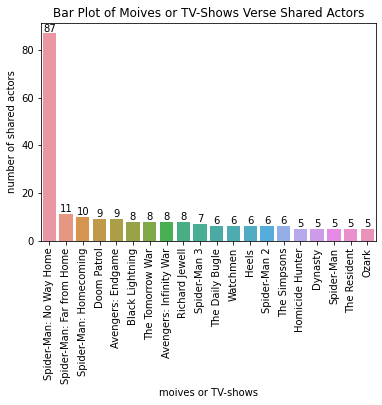

In [8]:
import seaborn as sns

df = df[:20]
ax = sns.barplot(x="movie_or_TV_name", y="number of shared actors", data=df)
ax.tick_params(axis='x', rotation=90)
for i in ax.containers:
    ax.bar_label(i,)
ax.set(xlabel='moives or TV-shows')
ax.set(title='Bar Plot of Moives or TV-Shows Verse Shared Actors')

As I expected, the moives Spider-Man 3, Spider-Man: Far From Home, and Avengers are on the top 20s. If you like the No Way Home, you may also like the other moives on the top 20s.
<br>
GitHub repository: 